**Table of contents**<a id='toc0_'></a>    
- 1. [Overview of Parkfield tremor/LFE activity  ](#toc1_)    
- 2. [Load datasets ](#toc2_)    
  - 2.1. [Local earthquakes ](#toc2_1_)    
  - 2.2. [Parkfield LFEs (Shelly) ](#toc2_2_)    
  - 2.3. [Tremorscope catalog (Nadeau) ](#toc2_3_)    
  - 2.4. [World tremor database (Ide) ](#toc2_4_)    
- 3. [Explicit cluster detection to measure synchronization](#toc3_)    
  - 3.1. [Cluster detection    ](#toc3_1_)    
  - 3.2. [Just one zone](#toc3_2_)    
- 4. [Correlation distance measure of synchronization](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Overview of Parkfield tremor/LFE activity   [&#128285;](#toc0_)

In [3]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import requests
import io

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

# 2. <a id='toc2_'></a>Load datasets  [&#128285;](#toc0_)

In [4]:
# General parameters
lon_range = [-121.2, -119.8]
lat_range = [35.3, 36.5]

fault_line = dict(N=dict(longitude=-121.029665, latitude=36.446555),
                  S=dict(longitude=-119.870418, latitude=35.323809))

parkfield = {'lon':-120.4327, 'lat':35.8997}
t = transect(parkfield['lon'], parkfield['lat'], fault_line['N']['longitude'], fault_line['N']['latitude'], fault_line['S']['longitude'], fault_line['S']['latitude'])
parkfield['xf'] = t[0]
parkfield['yf'] = t[1]

day0 = np.datetime64('2000-01-01')

## 2.1. <a id='toc2_1_'></a>Local earthquakes  [&#128285;](#toc0_)

In [5]:
# Load earthquakes
path = workdir + "projects/data/Catalogs/parkfield_ncsn_ddrt_00_23/parkfield_ncsn_ddrt_00_23.txt"

COLS = ['DateTime', 'lat', 'lon', 'depth', 'mag', 'MagType', 'NbStations', 'Gap', 'Distance', 'RMS', 'Source', 'EventID']
eq = pd.read_csv(
    path,
    names=COLS, 
    skiprows=1,
)

eq["date"] = pd.to_datetime(
     eq["DateTime"],
     format='%Y/%m/%d %H:%M:%S.%f',
)
eq.sort_values(by=["date"], inplace=True)
eq.day = (eq.date - day0) / np.timedelta64(1, 'D')

indicator = (
    (eq.lat > lat_range[0])
    & (eq.lat < lat_range[1])
    & (eq.lon > lon_range[0])
    & (eq.lon < lon_range[1])
)

eq = eq[indicator]

# Project earthquakes on fault
t = transect(eq.lon.values, eq.lat.values, fault_line['S']['longitude'], fault_line['S']['latitude'], fault_line['N']['longitude'], fault_line['N']['latitude'])
eq['xf'] = t[0] - parkfield['xf']
eq['yf'] = t[1]

eq_2004 = eq[eq.date.dt.year == 2004].sort_values(by=['mag'], ascending=False).iloc[0]
eq_2012 = eq[eq.date.dt.year == 2012].sort_values(by=['mag'], ascending=False).iloc[0]

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_16498/3976266833.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  eq.day = (eq.date - day0) / np.timedelta64(1, 'D')


## 2.2. <a id='toc2_2_'></a>Parkfield LFEs (Shelly)  [&#128285;](#toc0_)

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_16498/195395874.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  lfe = pd.read_csv(



Shelly LFEs
1.475910e+06 LFEs, spanning 2001--2022


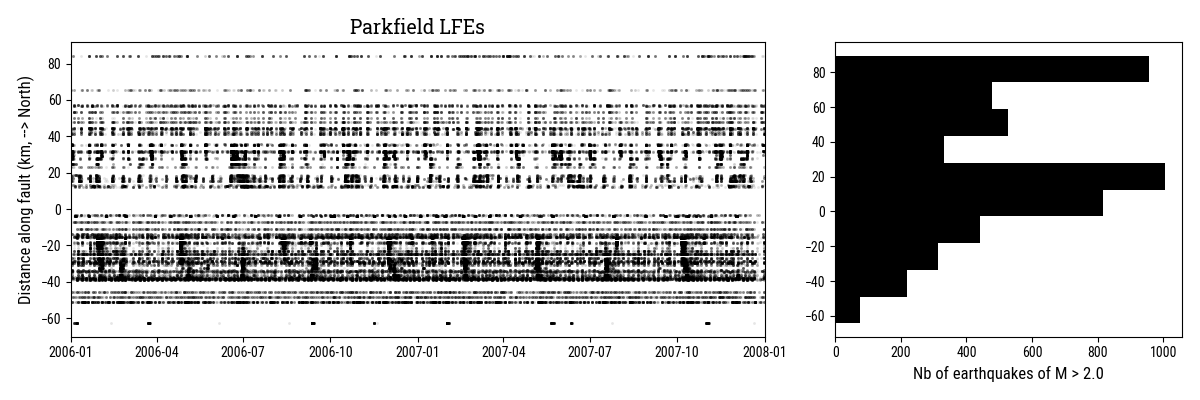

In [6]:
# Shelly catalog
# --> Load catalog
CAT_PATH = workdir + 'projects/data/Catalogs/saf_lfes/saf_lfes_shelly17_extended.txt'
COL_NAMES = [ "year", "month", "day", "s_of_day", "hour", "minute", "second", "ccsum", "meancc", 
             "med_cc", "seqday", "ID", "lat", "lon", "depth", "n_chan" ]
lfe = pd.read_csv(
    CAT_PATH,
    names=COL_NAMES,
    comment='%',
    delim_whitespace=True,
    index_col=False
    )
lfe["date"] = pd.to_datetime(lfe[["year", "month", "day", "hour", "minute", "second"]])
lfe.sort_values(by=["date"], inplace=True)
print('\nShelly LFEs')
print('{:e} LFEs, spanning {:d}--{:d}'.format(len(lfe), lfe.year.min(), lfe.year.max()))
day0 = np.datetime64('2000-01-01')
lfe['day'] = (lfe.date - day0).dt.days + (lfe.date - day0).dt.seconds/(24*3600)

# Project LFEs on fault
t = transect(lfe.lon.values, lfe.lat.values, fault_line['S']['longitude'], fault_line['S']['latitude'], fault_line['N']['longitude'], fault_line['N']['latitude'])
lfe['xf'] = t[0] - parkfield['xf']
lfe['yf'] = t[1]

# Plot
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

ax = fig.add_subplot(gs[0, 0])
ax.set_title('Parkfield LFEs', fontname='Roboto Slab', fontsize=14)
ax.set_ylabel('Distance along fault (km, --> North)')

ax.plot(lfe.date, lfe.xf, 'o', mec=[0,0,0,0], mfc=to_rgba('k', .1), ms=2)

ax.set_xlim(np.datetime64('2006-01-01'), np.datetime64('2008-01-01'))

ax = fig.add_subplot(gs[0, 1])
min_m = 2
ax.set_xlabel('Nb of earthquakes of M > {:.1f}'.format(min_m))
ax.hist(eq.xf[(eq.mag > 1.5) & (eq.yf < 20.) & (eq.date > np.datetime64('2006-06-01'))], bins=10, orientation='horizontal', color=to_rgba('k'))

plt.tight_layout()
plt.show()

## 2.3. <a id='toc2_3_'></a>Tremorscope catalog (Nadeau)  [&#128285;](#toc0_)

57252 tremor detections, spanning 2001--2017


/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_16498/2414249641.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  trm = pd.read_csv(
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_16498/2414249641.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12, 4))


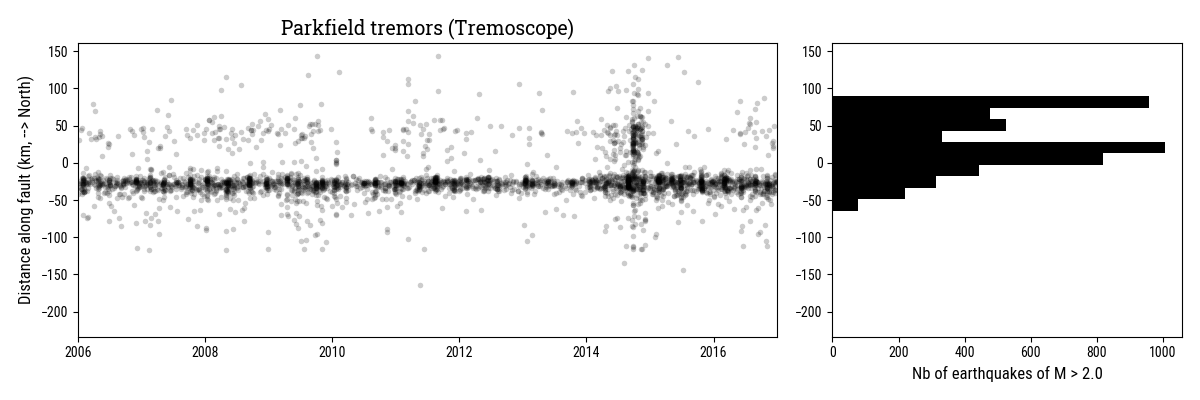

In [36]:
# Tremorscope
path = workdir + 'projects/data/Catalogs/parkfield_tremorscope_01_17/parkfield_tremorscope_01_17.txt'

names = ['date_str', 'lat', 'lon', 'depth', 'Nst', 'gap', 'qlt', 'dur', 'petot', 'notes']
trm = pd.read_csv(
    path,
    skiprows=1,
    delim_whitespace=True,
    names=names)

trm['date'] = pd.to_datetime(trm.date_str, format='%Y.%j,%H:%M:%S.%f')
day0 = np.datetime64('2001-07-27')
trm['day'] = (trm.date - day0) / np.timedelta64(1, 'D')

trm.sort_values(by=["date"], inplace=True)
trm.reset_index(drop=True, inplace=True)

# Only select correctly detected tremor
trm = trm[(trm.qlt == 'A') | (trm.qlt == 'B')]
trm.lon = trm.lon.values.astype(float)
trm.lat = trm.lat.values.astype(float)
trm.depth = trm.depth.values.astype(float)

print('{:d} tremor detections, spanning {:d}--{:d}'.format(trm.size, trm.date.min().year, trm.date.max().year))  

# Project tremors on the fault
t = transect(trm.lon.values, trm.lat.values, fault_line['S']['longitude'], fault_line['S']['latitude'], fault_line['N']['longitude'], fault_line['N']['latitude'])
trm['xf'] = t[0] - parkfield['xf']
trm['yf'] = t[1]

# Plot
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

ax = fig.add_subplot(gs[0, 0])
ax.set_title('Parkfield tremors (Tremoscope)', fontname='Roboto Slab', fontsize=14)
ax.set_ylabel('Distance along fault (km, --> North)')

ax.plot(trm.date, trm.xf, 'o', mec=[0,0,0,0], mfc=to_rgba('k', .2), ms=4)

ax.set_xlim(np.datetime64('2006-01-01'), np.datetime64('2017-01-01'))

ax = fig.add_subplot(gs[0, 1], sharey=ax)
min_m = 2
ax.set_xlabel('Nb of earthquakes of M > {:.1f}'.format(min_m))
ax.hist(eq.xf[(eq.mag > 1.5) & (eq.yf < 20.) & (eq.date > np.datetime64('2006-06-01'))], bins=10, orientation='horizontal', color=to_rgba('k'))

plt.tight_layout()
plt.show()

## 2.4. <a id='toc2_4_'></a>World tremor database (Ide)  [&#128285;](#toc0_)

44594 tremor detections, spanning 2005--2012


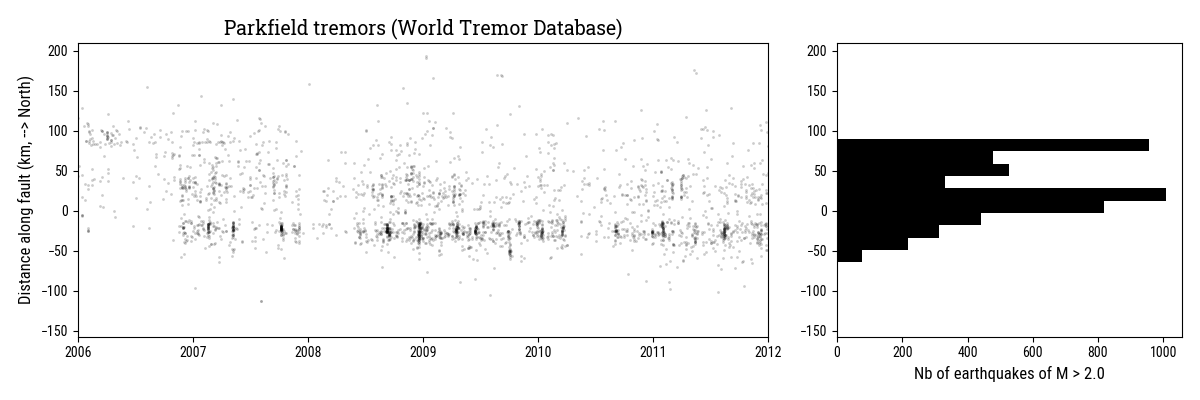

In [8]:
# World tremor database
path = workdir + 'projects/data/Catalogs/parkfield_wtb_05_12/parkfield_wtb_05_12.csv'

COLS = ['date', 'time', 'lat', 'lon', 'depth', 'mag', 'dur', 'err', 'optional_date']
wtd = pd.read_csv(
    path,
    names=COLS,
)

wtd['date_str'] = wtd.date.values + ' ' + wtd.time.values
wtd['date'] = pd.to_datetime(wtd.date_str)
day0 = np.datetime64('2005-01-28')
wtd['day'] = (wtd.date - day0) / np.timedelta64(1, 'D')

wtd.sort_values(by=["date"], inplace=True)
print('{:d} tremor detections, spanning {:d}--{:d}'.format(wtd.size, wtd.date.min().year, wtd.date.max().year))

# Project tremors on the fault
t = transect(wtd.lon.values, wtd.lat.values, fault_line['S']['longitude'], fault_line['S']['latitude'], fault_line['N']['longitude'], fault_line['N']['latitude'])
wtd['xf'] = t[0] - parkfield['xf']
wtd['yf'] = t[1]

# Plot
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

ax = fig.add_subplot(gs[0, 0])
ax.set_title('Parkfield tremors (World Tremor Database)', fontname='Roboto Slab', fontsize=14)
ax.set_ylabel('Distance along fault (km, --> North)')

ax.plot(wtd.date, wtd.xf, 'o', mec=[0,0,0,0], mfc=to_rgba('k', .2), ms=2)

ax.set_xlim(np.datetime64('2006-01-01'), np.datetime64('2012-01-01'))

ax = fig.add_subplot(gs[0, 1], sharey=ax)
min_m = 2
ax.set_xlabel('Nb of earthquakes of M > {:.1f}'.format(min_m))
ax.hist(eq.xf[(eq.mag > 1.5) & (eq.yf < 20.) & (eq.date > np.datetime64('2006-06-01'))], bins=10, orientation='horizontal', color=to_rgba('k'))

plt.tight_layout()
plt.show()  

---
# 3. <a id='toc3_'></a>Explicit cluster detection to measure synchronization [&#128285;](#toc0_)

## 3.1. <a id='toc3_1_'></a>Cluster detection     [&#128285;](#toc0_)

Good parameters:
- DBSCAN: `x0 = 1 day`, `t0 = 20 km`, `eps=.5 km`, `min_samples=400` for South

In [1]:
from sklearn.cluster import DBSCAN

Detected 835 clusters
Detected 835 clusters
Min, median, max number of LFEs in a cluster: 95, 354.5, 14463


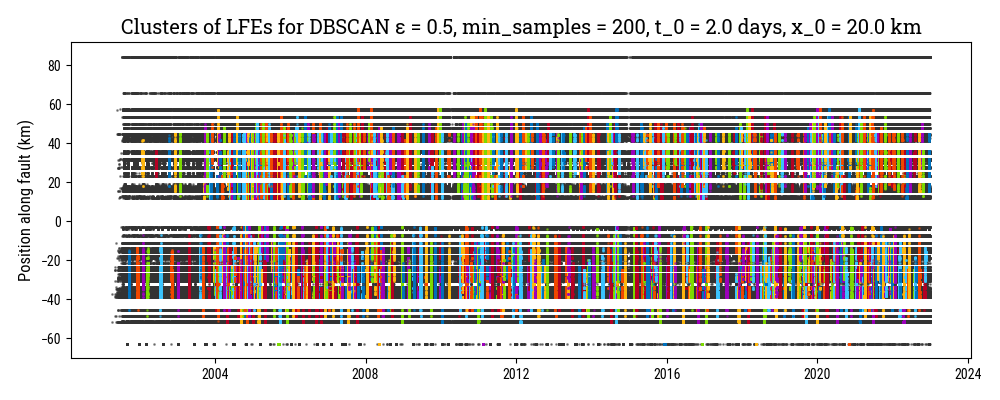

In [92]:
# Parameters for cluster detection
ev_x = lfe['xf'].values
ev_t = lfe['day'].values

t0 = 2. # scaling factor for time (in days)
x0 = 20. # scaling factor for position (in km)

X = np.column_stack([ev_x / x0, ev_t / t0])

# Parameters for the clustering model
dbs = DBSCAN(eps=.5, min_samples=200)

# Fit the model
clusters_fit = dbs.fit(X)

print('Detected {:d} clusters'.format(len(np.unique(clusters_fit.labels_))))

# Stats on the clusters
print('Detected {:d} clusters'.format(len(np.unique(clusters_fit.labels_))))
print('Min, median, max number of LFEs in a cluster: {:}, {:}, {:}'.format(np.min(np.bincount(clusters_fit.labels_+1)[1:]), np.median(np.bincount(clusters_fit.labels_+1)[1:]), np.max(np.bincount(clusters_fit.labels_+1)[1:])))

# Show clusters
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title('Clusters of LFEs for DBSCAN ε = {:}, min_samples = {:}, t_0 = {:} days, x_0 = {:} km'.format(dbs.eps, dbs.min_samples, t0, x0), fontname='Roboto Slab')
ax.set_ylabel('Position along fault (km)')
# ax.set_xlim(np.datetime64('2018-01-01'), np.datetime64('2019-01-01'))

ax.plot(lfe.date, lfe.xf, 'o', ms=1, alpha=0.5, c='.2')

for cluster in np.unique(clusters_fit.labels_):
    if cluster == -1:
        continue
    idx = clusters_fit.labels_ == cluster
    ax.plot(lfe.date.values[idx], lfe.xf.values[idx], 'o', ms=1, alpha=0.5)
plt.tight_layout()
plt.show()

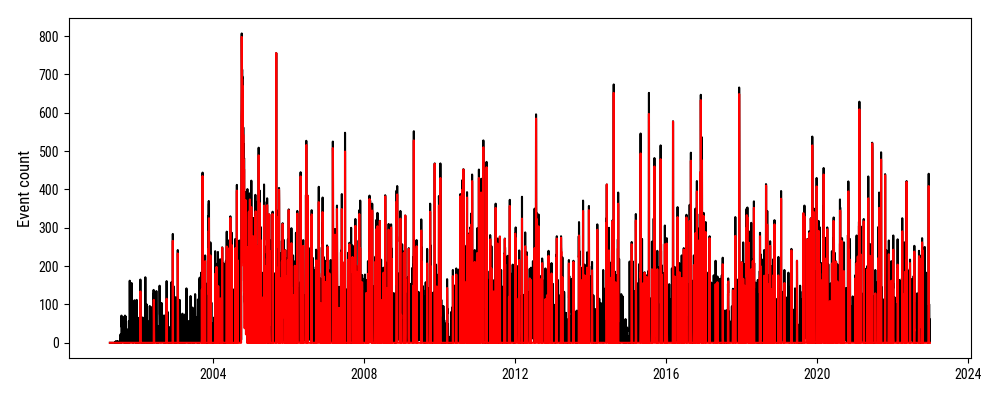

In [94]:
# Check coincidence between clustered LFEs and all of them
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_ylabel('Event count')
count_all, bins = np.histogram(lfe[lfe.xf > 0].date.values, bins=np.arange(lfe.date.min(), lfe.date.max(), np.timedelta64(1, 'D')))
ax.plot(bins[:-1], count_all, label='All LFEs', c='k')
count_clust, bins = np.histogram(lfe[(lfe.xf > 0) & (clusters_fit.labels_ != -1)].date, bins=np.arange(lfe.date.min(), lfe.date.max(), np.timedelta64(1, 'D')))
ax.plot(bins[:-1], count_clust, label='Clustered LFEs', c='r')
plt.tight_layout()
plt.show()

In [95]:
# Make clusters dataframe
lfe['cluster_id'] = clusters_fit.labels_

# Group LFEs by cluster ID
cluster_groups = lfe.groupby('cluster_id')

# Initialize an empty dataframe to store cluster information
clusters_df = pd.DataFrame(columns=['id',
                                    'n_ev',
                                    't_first',
                                    't_last',
                                    'x_min',
                                    'x_max',
                                    'z_min',
                                    'z_max',
                                    't_centroid',
                                    'x_centroid',
                                    'z_centroid',
                                    't_first80',
                                    't_last80',
                                    'x_min90',
                                    'x_max90',
                                    'duration80'])

# Loop over the cluster groups and compute statistics for each cluster
for cluster_id, cluster_data in cluster_groups:
    if cluster_id == -1:
        continue
    n_ev = len(cluster_data)
    t_first = cluster_data['date'].min()
    t_last = cluster_data['date'].max()
    x_min = cluster_data['xf'].min()
    x_max = cluster_data['xf'].max()
    z_min = cluster_data['depth'].min()
    z_max = cluster_data['depth'].max()
    t_centroid = np.percentile(cluster_data['date'], 50)
    x_centroid = np.median(cluster_data['xf'])
    z_centroid = np.median(cluster_data['depth'])
    t_first80 = np.percentile(cluster_data['date'], 10)
    t_last80 = np.percentile(cluster_data['date'], 90)
    x_min90 = np.percentile(cluster_data['xf'], 5)
    x_max90 = np.percentile(cluster_data['xf'], 95)
    duration80 = (t_last80 - t_first80) / np.timedelta64(1, 's')  # in seconds
    span90 = x_max90 - x_min90

    # Add cluster information to the dataframe
    clusters_df.loc[len(clusters_df)] = [cluster_id, n_ev, t_first, t_last, x_min, x_max, z_min, z_max, t_centroid, x_centroid, z_centroid, t_first80, t_last80, x_min90, x_max90, duration80] 

## 3.2. <a id='toc3_2_'></a>Just one zone [&#128285;](#toc0_)

In [96]:
# Define bin and select clusters
bin_xmin = 0
bin_xmax = 50

q_min_span = .2  # proportion of bin to span for cluster to be considere

fully_cross_bin = (clusters_df.x_min <= bin_xmin) & (clusters_df.x_max >= bin_xmax)
xmax_in_bin = (clusters_df.x_max >= bin_xmin) & (clusters_df.x_max <= bin_xmax)
xmin_in_bin = (clusters_df.x_min >= bin_xmin) & (clusters_df.x_min <= bin_xmax)

cluster_in_bin = fully_cross_bin | xmax_in_bin | xmin_in_bin

size_in_bin = np.array([min(bin_xmax, clust_xmax) for clust_xmax in clusters_df.x_max]) - np.array([max(bin_xmin, clust_xmin) for clust_xmin in clusters_df.x_min])

bin_spanning_clusters = cluster_in_bin & (size_in_bin >= q_min_span * (bin_xmax - bin_xmin))

selected_clusters = clusters_df[bin_spanning_clusters]

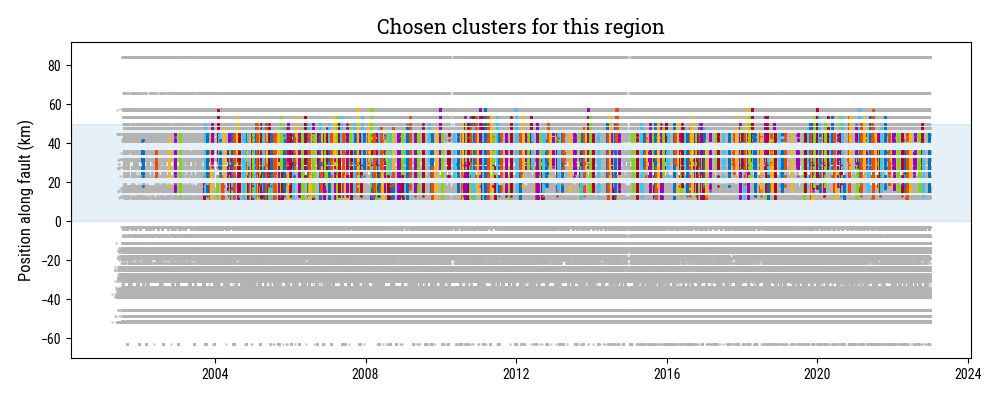

In [97]:
# Show
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title('Chosen clusters for this region', fontname='Roboto Slab')
ax.set_ylabel('Position along fault (km)')

ax.axhspan(bin_xmin, bin_xmax, color='C0', alpha=.1)

ax.plot(lfe.date, lfe.xf, 'o', ms=1, alpha=0.5, c='.7')

for cluster in selected_clusters.id:
    if cluster == -1:
        continue
    idx = clusters_fit.labels_ == cluster
    ax.plot(lfe.date.values[idx], lfe.xf.values[idx], 'o', ms=1, alpha=0.5)
plt.tight_layout()
plt.show()

In [98]:
# Compute different measures of synchronization
# --> Clustering index: how many events that occur in this bin are within the selected clusters for this bin
n_ev_in_bin = len(lfe[(lfe.xf >= bin_xmin) & (lfe.xf <= bin_xmax)])
n_ev_in_clusters = len(lfe[(lfe.xf >= bin_xmin) & (lfe.xf <= bin_xmax) & np.in1d(lfe.cluster_id.values, selected_clusters.id.values)])

print('Proportion of events in bin-spanning clusters: {:.2f}\n'.format(n_ev_in_clusters / n_ev_in_bin))

# --> Periodicity detection and its COV
selected_clusters_dT = np.diff(selected_clusters.t_centroid.values) / np.timedelta64(1, 'D')
mean_dT = np.mean(selected_clusters_dT)
std_dT = np.std(selected_clusters_dT)
cov_dT = std_dT / mean_dT

print('Mean period: {:.2f} days ({:.2f} months)'.format(mean_dT, mean_dT / 30.5))
print('Standard deviation of period: {:.2f} days ({:.2f} months)'.format(std_dT, mean_dT / 30.5))
print('Coefficient of variation of period (periodicity): {:.2f}'.format(cov_dT))

Proportion of events in bin-spanning clusters: 0.48

Mean period: 20.57 days (0.67 months)
Standard deviation of period: 20.98 days (0.67 months)
Coefficient of variation of period (periodicity): 1.02


---
# 4. <a id='toc4_'></a>Correlation distance measure of synchronization [&#128285;](#toc0_)

In [39]:
# Make the matrix of cross-correlation — Parameters
from stats import cross_corr
# --> Define the spatial bins
dx_bin = 5  # in km, width of bin
xmin_bin = -52
xmax_bin = 60
x_bin_edges = np.arange(xmin_bin, xmax_bin + dx_bin, dx_bin)

# --> Parameters for the temporal counts
delta = 1  # in days, width of the temporal bin to count tremor events

# --> Parameters for the correlation
norm = True
no_bias = False
look_both_ways = True  # to add the negative lags to the positive

# --> Minimum speed of communication to consider (affects where we look for maximum lag)
v_min = .5  # in km/day

In [40]:
# Make the matrix of cross-correlation — Computation
# --> Make the counts
count_time = np.arange(0, lfe.day.max()+delta, delta)
counts = np.zeros((len(x_bin_edges)-1, len(count_time)-1))

for ii in range(len(x_bin_edges)-1):  
    x_min = x_bin_edges[ii]
    x_max = x_bin_edges[ii+1]
    lfe_in_bin = lfe.xf.between(x_min, x_max)
    counts[ii, :] = np.histogram(lfe[lfe_in_bin].day.values, bins=count_time)[0]

# --> Compute the cross-correlation matrix
cc_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))
lag_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))

for ii in range(len(x_bin_edges)-1):
    for jj in range(len(x_bin_edges)-1):
        if jj <= ii:
            cc, lag = cross_corr(counts[ii, :], counts[jj, :], delta, norm=norm, no_bias=no_bias)
            
            if look_both_ways:
                cc = (cc + cc[::-1]) / 2
                cc = cc[lag >= 0]
                lag = lag[lag >= 0]
            
            in_window = np.abs(lag) <= abs((x_bin_edges[ii+1] + x_bin_edges[ii]) - (x_bin_edges[jj+1] + x_bin_edges[jj]) / 2) / v_min
            cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc[in_window])
            lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[in_window][np.argmax(cc[in_window])]
            # cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc)
            # lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[np.argmax(cc)]

/Users/gaspard/Documents/work/py_modules/my_modules/stats.py:256: RuntimeWarning: invalid value encountered in divide
  sig1 = (sig1 - np.mean(sig1)) / (np.std(sig1)*len(sig1))
/Users/gaspard/Documents/work/py_modules/my_modules/stats.py:257: RuntimeWarning: invalid value encountered in divide
  sig2 = (sig2 - np.mean(sig2)) / np.std(sig2)


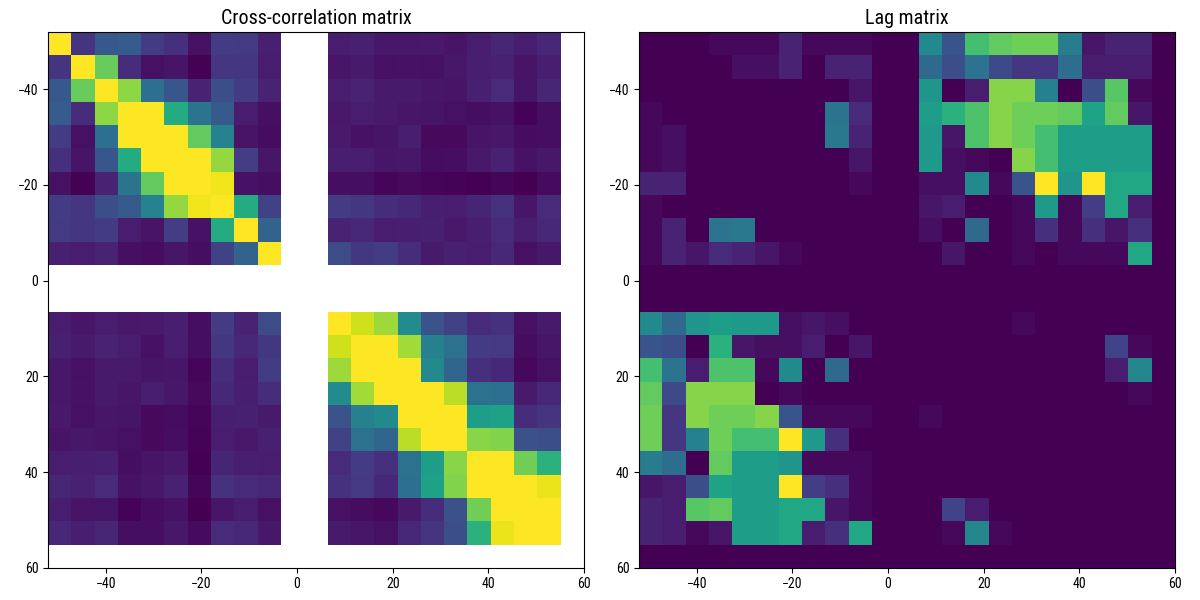

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]

# cc_matrix_sm = ssg.convolve2d(cc_matrix, np.ones((3, 3)), mode='full') / 9

cax = ax.imshow(cc_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmax_bin, xmin_bin], vmax=.5)
ax.set_title('Cross-correlation matrix')

ax = axes[1]
cax = ax.imshow(lag_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmax_bin, xmin_bin], vmin=0, vmax=50)
ax.set_title('Lag matrix')

plt.tight_layout()
plt.show()

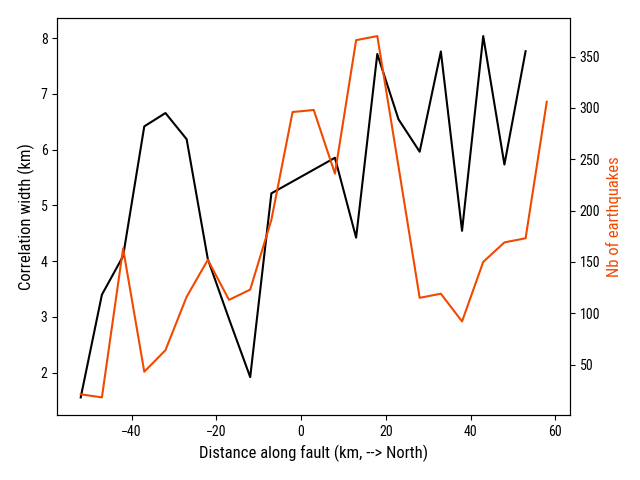

In [48]:
# Compute the correlation distances
left_width = []
right_width = []

# Remove rows and columns of the matrix that have no data
x_bin_edges_no0 = x_bin_edges[:-1][~np.all(np.isnan(cc_matrix), axis=1)]
cc_matrix_no0 = cc_matrix[~np.all(np.isnan(cc_matrix), axis=1)]
cc_matrix_no0 = cc_matrix_no0[:, ~np.all(np.isnan(cc_matrix_no0), axis=0)]

from scipy.optimize import curve_fit

for ii in range(len(x_bin_edges_no0)):
    x0 = x_bin_edges_no0[ii]

    def lorentzian_at_x0(x, gamma):
        c = np.quantile(cc_matrix_no0[ii, :], .10)
        return (1-c) / (1 + (x - x0)**2 / gamma**2) + c

    if ii < 10:
        popt_right, pcov_right = curve_fit(lorentzian_at_x0, x_bin_edges_no0[ii:], cc_matrix_no0[ii, ii:], p0=[1])

        left_width.append(0)
        right_width.append(popt_right[0])
    elif ii > len(x_bin_edges_no0) - 10:
        popt_left, pcov_left = curve_fit(lorentzian_at_x0, x_bin_edges_no0[:ii+1], cc_matrix_no0[ii, :ii+1], p0=[1])

        left_width.append(popt_left[0])
        right_width.append(0)
    else:
        popt_left, pcov_left = curve_fit(lorentzian_at_x0, x_bin_edges_no0[:ii+1], cc_matrix_no0[ii, :ii+1], p0=[1])
        popt_right, pcov_right = curve_fit(lorentzian_at_x0, x_bin_edges_no0[ii:], cc_matrix_no0[ii, ii:], p0=[1])

        left_width.append(popt_left[0])
        right_width.append(popt_right[0])

fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Correlation width (km)')
# ax.plot(x_bin_edges_no0[:-1], left_width, label='Left width')
# ax.plot(x_bin_edges_no0[:-1], right_width, label='Right width')

ax.plot(x_bin_edges_no0, [max(l, r) for l, r in zip(left_width, right_width)], label='Max width', color='k')

ax_ = ax.twinx()
n_eq_bin = np.histogram(eq.xf[(eq.mag > 1.5) & (eq.yf < 20.) & (eq.date > np.datetime64('2006-06-01'))], bins=x_bin_edges)[0]
ax_.plot(x_bin_edges[:-1], n_eq_bin, label='Right width', color='C1')
ax_.set_ylabel('Nb of earthquakes', color='C1')

plt.tight_layout()
plt.show()

In [99]:
lfe

,year,month,day,s_of_day,hour,minute,second,ccsum,meancc,med_cc,seqday,ID,lat,lon,depth,n_chan,date,xf,yf,cluster_id
0,2001,4,461.497905,43019.35,11,56,59.35,4.57,0.381,0.456,37,58459s,35.620,-120.185,25.75,12,2001-04-06 11:56:59.350,-37.317563,0.607927,-1
1,2001,4,464.938206,81061.60,22,31,1.60,4.96,0.413,0.475,40,33861s,35.530,-120.075,28.50,12,2001-04-09 22:31:01.600,-51.400883,-0.576751,-1
2,2001,4,485.878241,75880.85,21,4,40.85,4.25,0.354,0.436,61,32192s,35.700,-120.280,21.00,12,2001-04-30 21:04:40.850,-24.961420,1.468239,-1
3,2001,5,487.855729,73935.25,20,32,15.25,5.25,0.437,0.479,63,58459s,35.620,-120.185,25.75,12,2001-05-02 20:32:15.250,-37.317563,0.607927,-1
4,2001,5,488.369433,31919.00,8,51,59.00,4.09,0.341,0.390,64,32192s,35.700,-120.280,21.00,12,2001-05-03 08:51:59.000,-24.961420,1.468239,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475905,2022,12,8400.069444,6000.25,1,40,0.25,4.67,0.222,0.238,7976,35503s,35.790,-120.340,25.00,21,2022-12-31 01:40:00.250,-13.800661,-0.816317,-1
1475906,2022,12,8400.188947,16325.80,4,32,5.80,4.96,0.236,0.204,7976,18319ss,36.055,-120.585,23.00,21,2022-12-31 04:32:05.800,23.055740,-2.801779,-1
1475907,2022,12,8400.189167,16344.40,4,32,24.40,4.64,0.221,0.223,7976,18319ss,36.055,-120.585,23.00,21,2022-12-31 04:32:24.400,23.055740,-2.801779,-1
1475908,2022,12,8400.822685,71080.65,19,44,40.65,4.11,0.187,0.181,7976,44437s,35.540,-120.110,26.50,22,2022-12-31 19:44:40.650,-48.504680,1.135309,-1


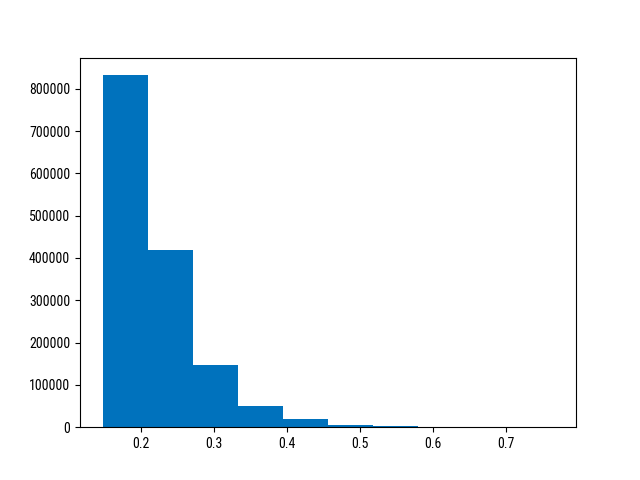

In [110]:
plt.figure()
plt.hist(lfe.meancc)
plt.show()

In [109]:
np.median(lfe.meancc)

0.201

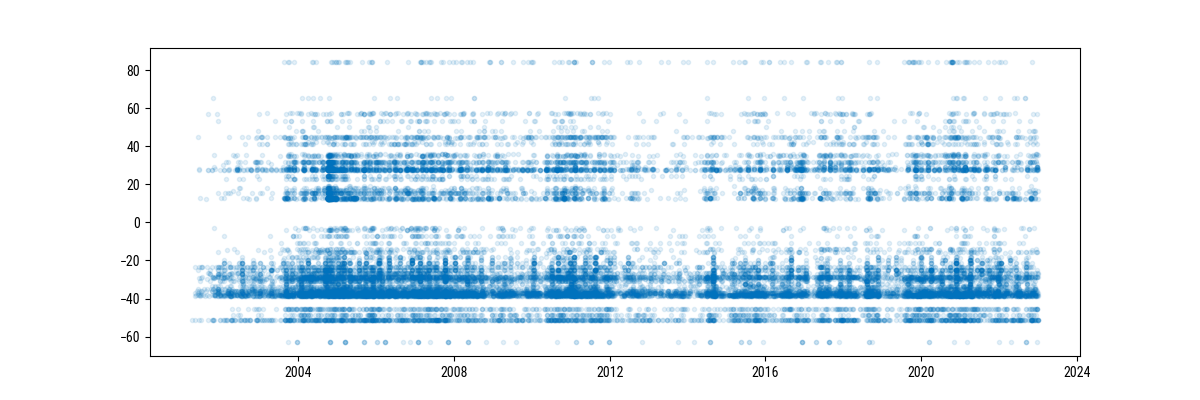

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(lfe[lfe.meancc > .4].date, lfe[lfe.meancc > .4].xf, 'o', ms=3, alpha=0.1)
plt.show()